In [5]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank
)
import json
import shap
from numpy.lib.stride_tricks import sliding_window_view
from darts.explainability.explainability_result import ComponentBasedExplainabilityResult

In [6]:
result_path = 'results/LSTM/'

In [7]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

df = pd.read_csv("data/ground_station_clean.csv")

In [8]:
encoders = {
    "cyclic":{
        "past":["month","dayofyear","day","hour","minute"],
    },
    "transformer": Scaler()
}

In [9]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_forecasts = None
# Define model parameters

# Set up time series cross-validation with 5 folds, respecting temporal order of data
tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTraining the model...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Fit the scaler only on training data to avoid data leakage
    scaler = scaler.fit(train_fold)
    # Transform all time series
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = BlockRNNModel(
        model="LSTM",
        model_name=f"model_{fold+1}",
        input_chunk_length=30,
        hidden_dim=173,
        n_rnn_layers=1,
        n_epochs=100,
        batch_size=21,
        dropout=0.24962139482829848,
        add_encoders=encoders,
        output_chunk_length=1,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,    
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.0012420237064857016, "weight_decay": 1e-6},  # Define learning rate and weight decay
    )
    model.fit(
        series=[train_scaled],
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11}
    )

    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    # Generate historical forecasts to evaluate model performance on past data
    forecasts = model.historical_forecasts(
        train_scaled,
        start=0.8,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        last_points_only=True,
    )


    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(train_scaled).split_after(0.8)[1]

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Training the model...
Train set: 1389 samples
Validation set: 1384 samples


/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24962139482829848 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('AMD Radeon RX 6700 XT') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 6.259


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.255


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 6.247


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.243


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 6.240


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.237


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.234


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 6.232


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 6.230


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 6.230. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24962139482829848 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/li

O R2 desse fold foi -1.1553393507190015

Fold 2

Training the model...
Train set: 2773 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.003. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24962139482829848 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/li

O R2 desse fold foi 0.8780958465296751

Fold 3

Training the model...
Train set: 4157 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24962139482829848 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/li

O R2 desse fold foi -inf

Fold 4

Training the model...
Train set: 5541 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.009. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24962139482829848 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/li

O R2 desse fold foi -inf

Fold 5

Training the model...
Train set: 6925 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.013. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24962139482829848 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


O R2 desse fold foi -52.15973953322853
O melhor fold foi 2


In [10]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24962139482829848 and num_layers=1


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=173, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.24962139482829848, activation=ReLU, model_name=model_2, input_chunk_length=30, n_epochs=100, batch_size=21, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler}, output_chunk_length=1, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fe58a2a3c50>]}, loss_fn=HuberLoss(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0012420237064857016, 'weight_decay': 1e-06})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE        RMSE         MAE        R2  \
Temperature                    5.558873    2.357726    1.838570  0.876895   
Precipitation_accumulated    379.368227   19.477377   12.893661  0.990867   
Humidity                      17.008116    4.124090    2.827907  0.910350   
Wind_Speed_kmh                 0.061232    0.247450    0.199400  0.797882   
Soil_Moisture              50637.253910  225.027229  144.083123  0.961440   
Soil_Temperature               8.839292    2.973095    1.985988  0.808266   
Wind_Dir_Sin                   0.072300    0.268886    0.166877  0.788843   
Wind_Dir_Cos                   0.121156    0.348074    0.214518  0.808984   

                                SMAPE  
Temperature                 12.899318  
Precipitation_accumulated   26.109912  
Humidity                     3.804062  
Wind_Speed_kmh              92.046702  
Soil_Moisture                2.

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM//previsao_vs_real_1.png


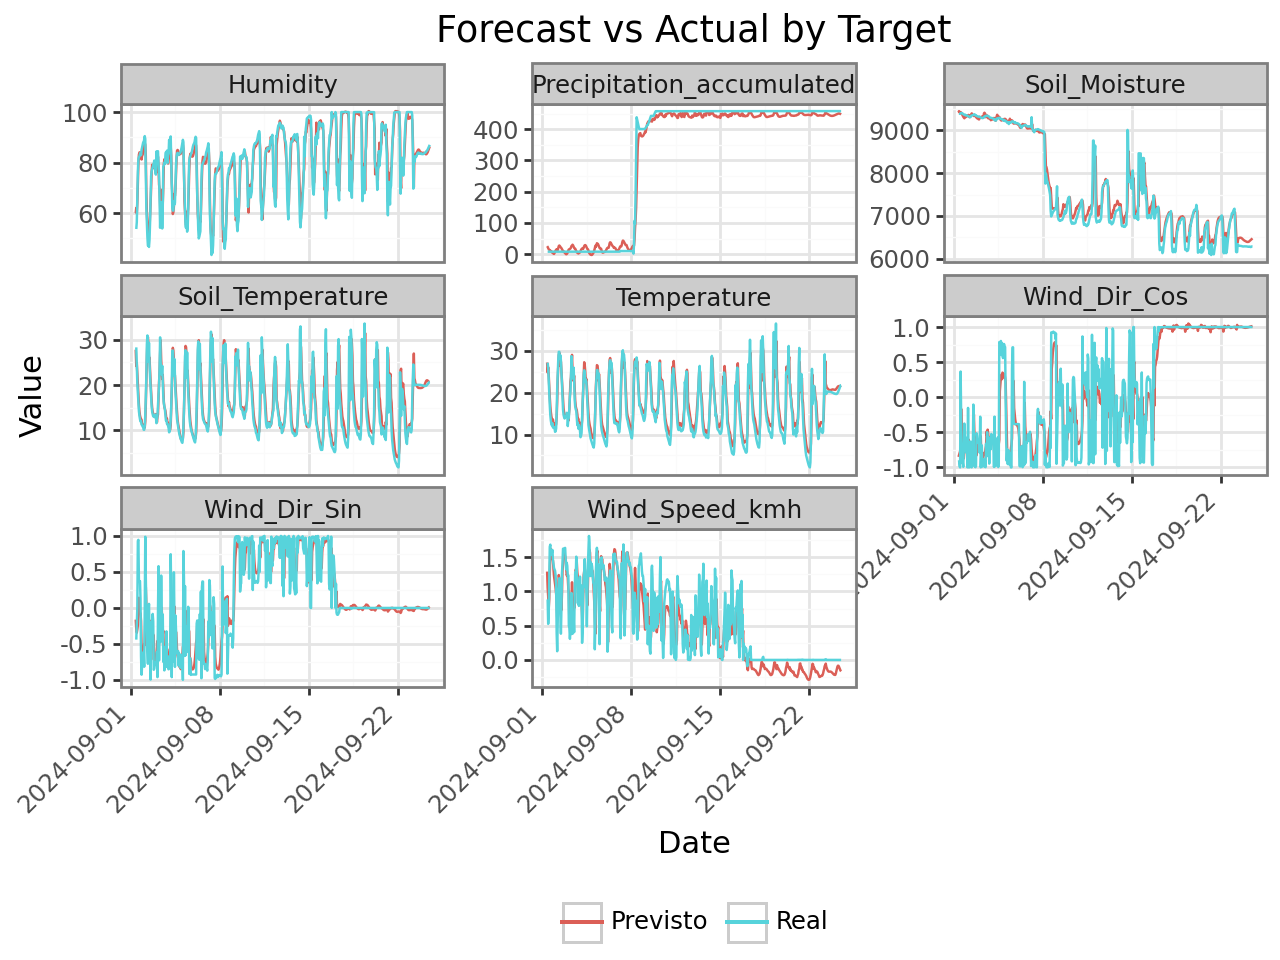

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    27.656413    5.258936    4.474709  0.385284   
Precipitation_accumulated    1507.378183   38.824969   25.114949  0.963348   
Humidity                       61.823622    7.862800    6.457949  0.671493   
Wind_Speed_kmh                  0.118811    0.344690    0.292115  0.609478   
Soil_Moisture              175892.247434  419.395097  323.366336  0.864614   
Soil_Temperature               26.878681    5.184465    4.327671  0.414958   
Wind_Dir_Sin                    0.083506    0.288975    0.197386  0.756483   
Wind_Dir_Cos                    0.177564    0.421384    0.282029  0.719300   

                                SMAPE  
Temperature                 29.754068  
Precipitation_accumulated   38.579251  
Humidity                     8.257114  
Wind_Speed_kmh              98.238836  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM//previsao_vs_real_6.png


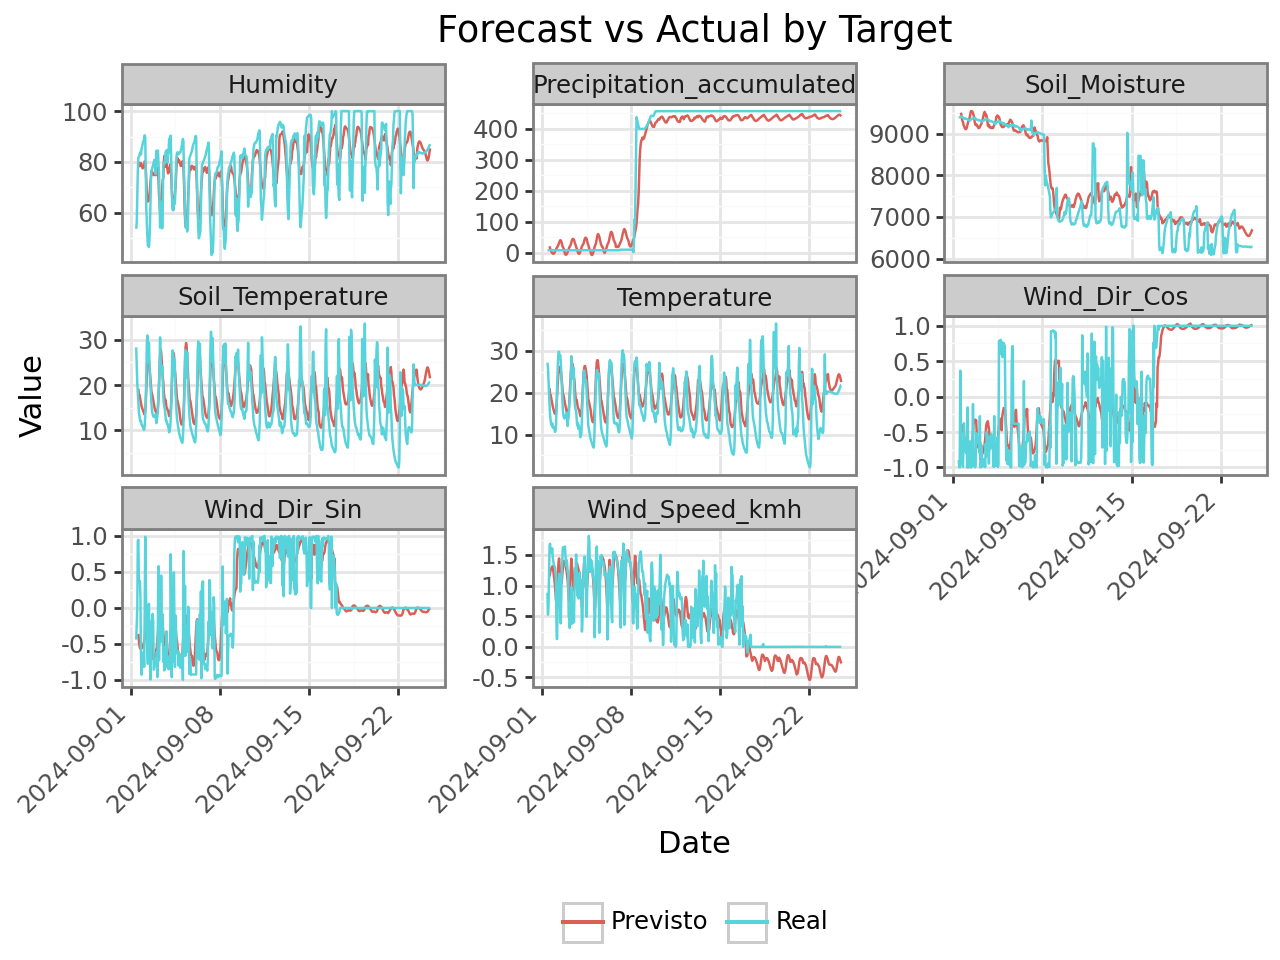

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    40.630854    6.374234    5.257156  0.104768   
Precipitation_accumulated    2635.512013   51.337238   32.728221  0.934889   
Humidity                       70.992231    8.425689    7.074051  0.626829   
Wind_Speed_kmh                  0.103722    0.322059    0.269863  0.649265   
Soil_Moisture              229088.309509  478.631705  384.016309  0.820611   
Soil_Temperature               38.701529    6.221055    5.130913  0.165506   
Wind_Dir_Sin                    0.082576    0.287361    0.195723  0.759889   
Wind_Dir_Cos                    0.198243    0.445245    0.296052  0.685166   

                                SMAPE  
Temperature                 33.907006  
Precipitation_accumulated   40.175271  
Humidity                     8.952715  
Wind_Speed_kmh              97.115865  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM//previsao_vs_real_12.png


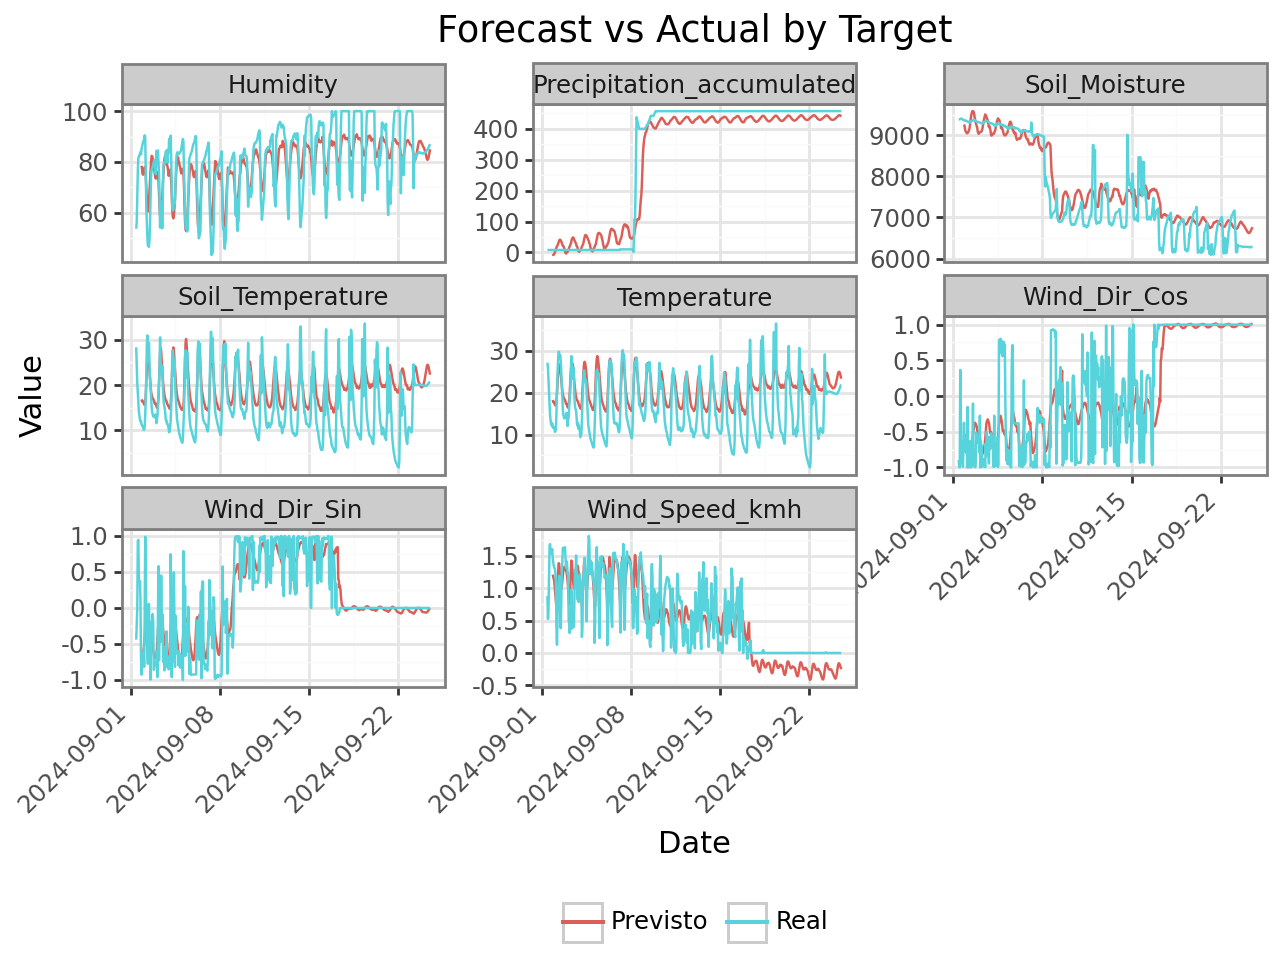

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    44.170099    6.646059    5.450059  0.025474   
Precipitation_accumulated    4163.640596   64.526278   42.931700  0.893398   
Humidity                       67.225006    8.199086    6.835666  0.646347   
Wind_Speed_kmh                  0.107330    0.327612    0.273510  0.634281   
Soil_Moisture              265496.929220  515.263941  427.853198  0.784695   
Soil_Temperature               42.306345    6.504333    5.350355  0.084952   
Wind_Dir_Sin                    0.102021    0.319407    0.211691  0.700089   
Wind_Dir_Cos                    0.245534    0.495514    0.336477  0.607963   

                                SMAPE  
Temperature                 34.784650  
Precipitation_accumulated   44.698733  
Humidity                     8.612840  
Wind_Speed_kmh              98.929329  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM//previsao_vs_real_24.png


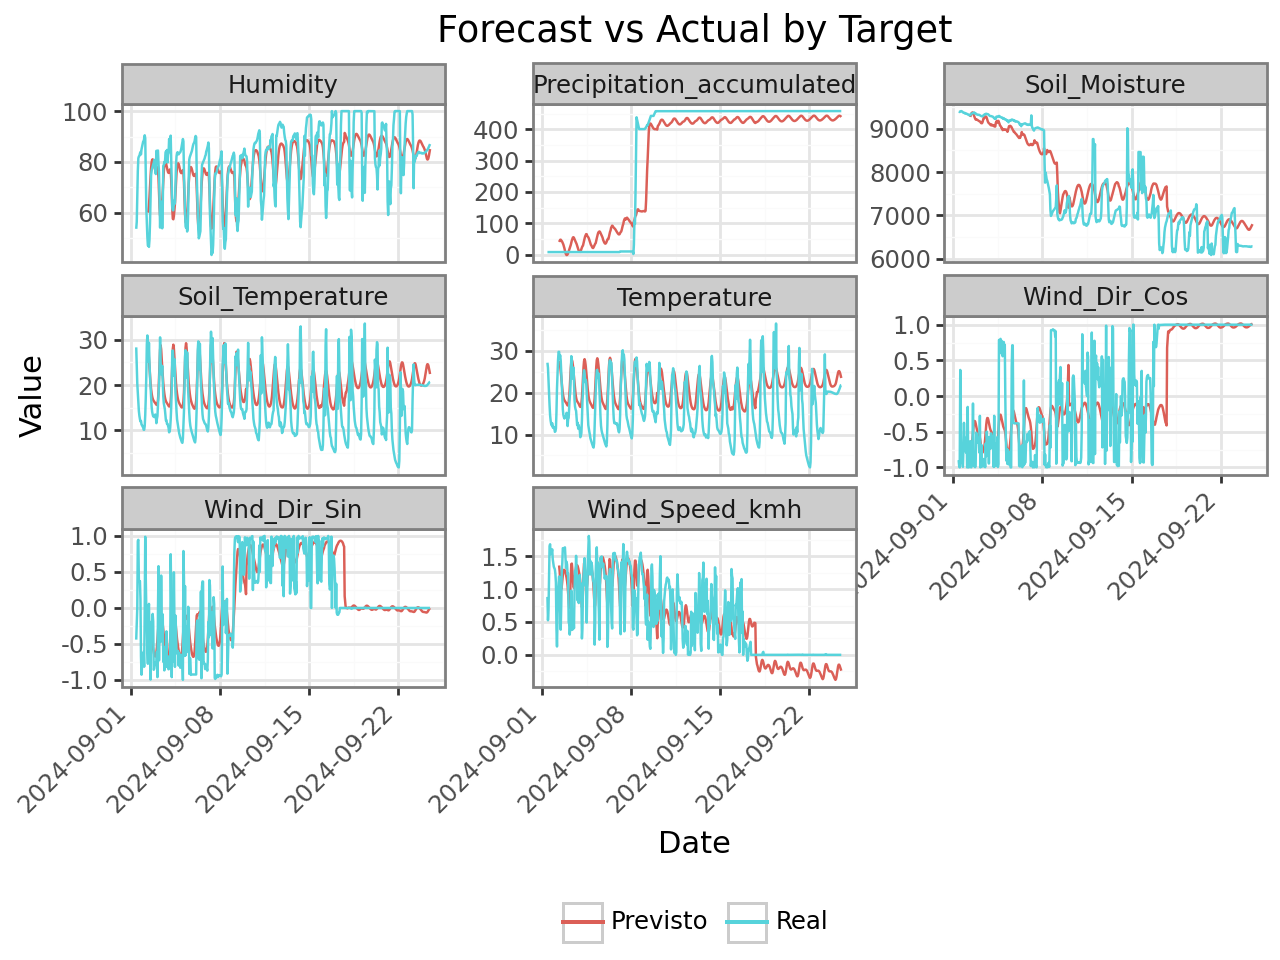

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    44.910162    6.701504    5.527628  0.011289   
Precipitation_accumulated    4155.533067   64.463424   49.496052  0.883513   
Humidity                       70.901521    8.420304    7.034259  0.617897   
Wind_Speed_kmh                  0.111902    0.334518    0.281818  0.605061   
Soil_Moisture              327670.509028  572.425112  494.644647  0.710002   
Soil_Temperature               43.462164    6.592584    5.486395  0.062691   
Wind_Dir_Sin                    0.156771    0.395943    0.272000  0.529211   
Wind_Dir_Cos                    0.329818    0.574298    0.404294  0.461879   

                                SMAPE  
Temperature                 35.452505  
Precipitation_accumulated   43.550633  
Humidity                     8.753767  
Wind_Speed_kmh             101.685638  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM//previsao_vs_real_48.png


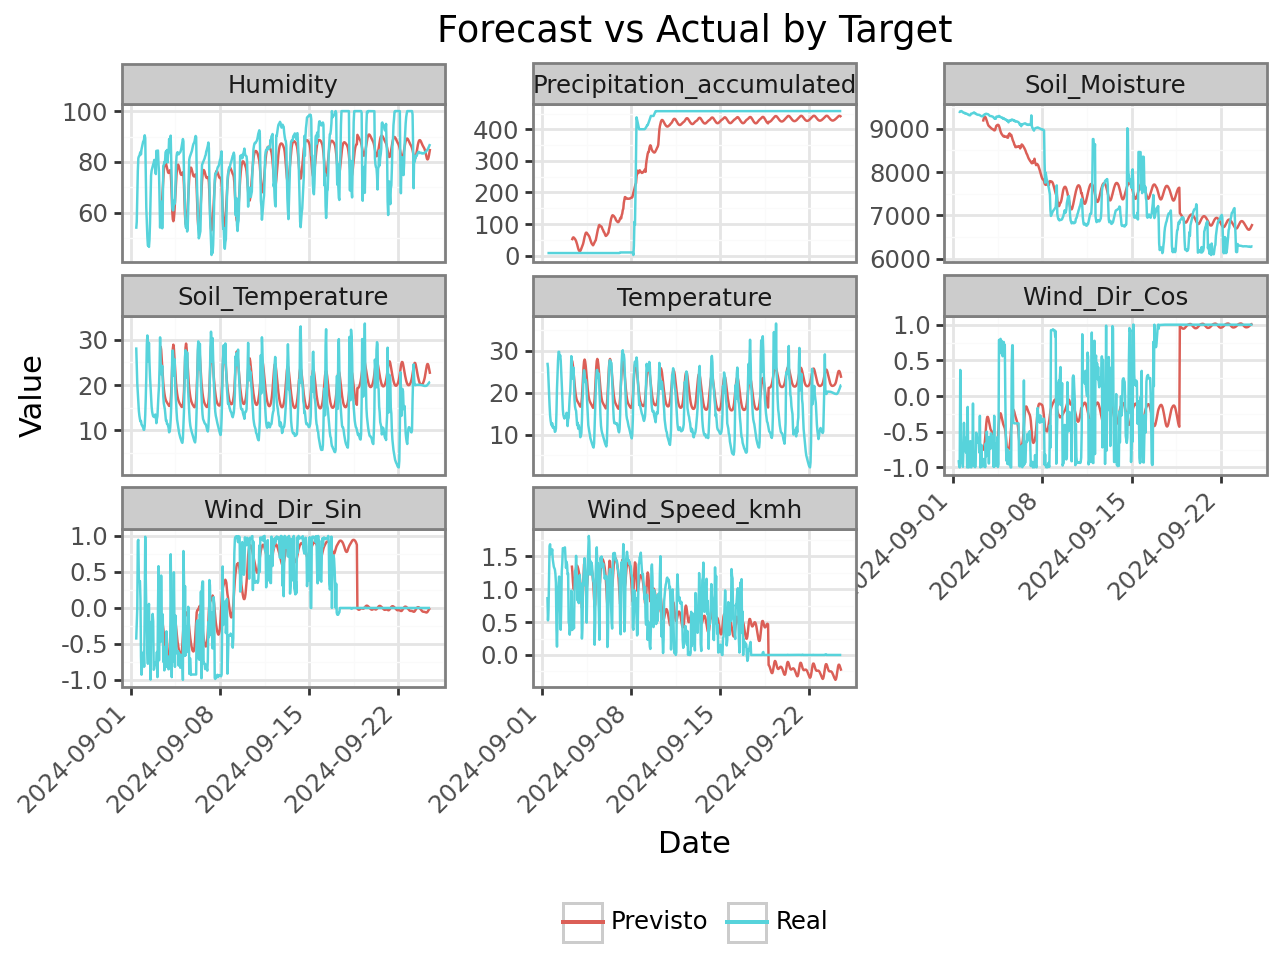

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    44.478446    6.669216    5.511493  0.035274   
Precipitation_accumulated    5383.608556   73.373078   50.910208  0.828613   
Humidity                       75.235361    8.673832    7.213894  0.599277   
Wind_Speed_kmh                  0.115781    0.340267    0.295255  0.592403   
Soil_Moisture              439507.522633  662.953635  572.818454  0.562914   
Soil_Temperature               43.408594    6.588520    5.520244  0.075307   
Wind_Dir_Sin                    0.218250    0.467172    0.327637  0.314422   
Wind_Dir_Cos                    0.432182    0.657406    0.481576  0.278831   

                                SMAPE  
Temperature                 35.535561  
Precipitation_accumulated   39.161736  
Humidity                     8.946610  
Wind_Speed_kmh             105.534162  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM//previsao_vs_real_72.png


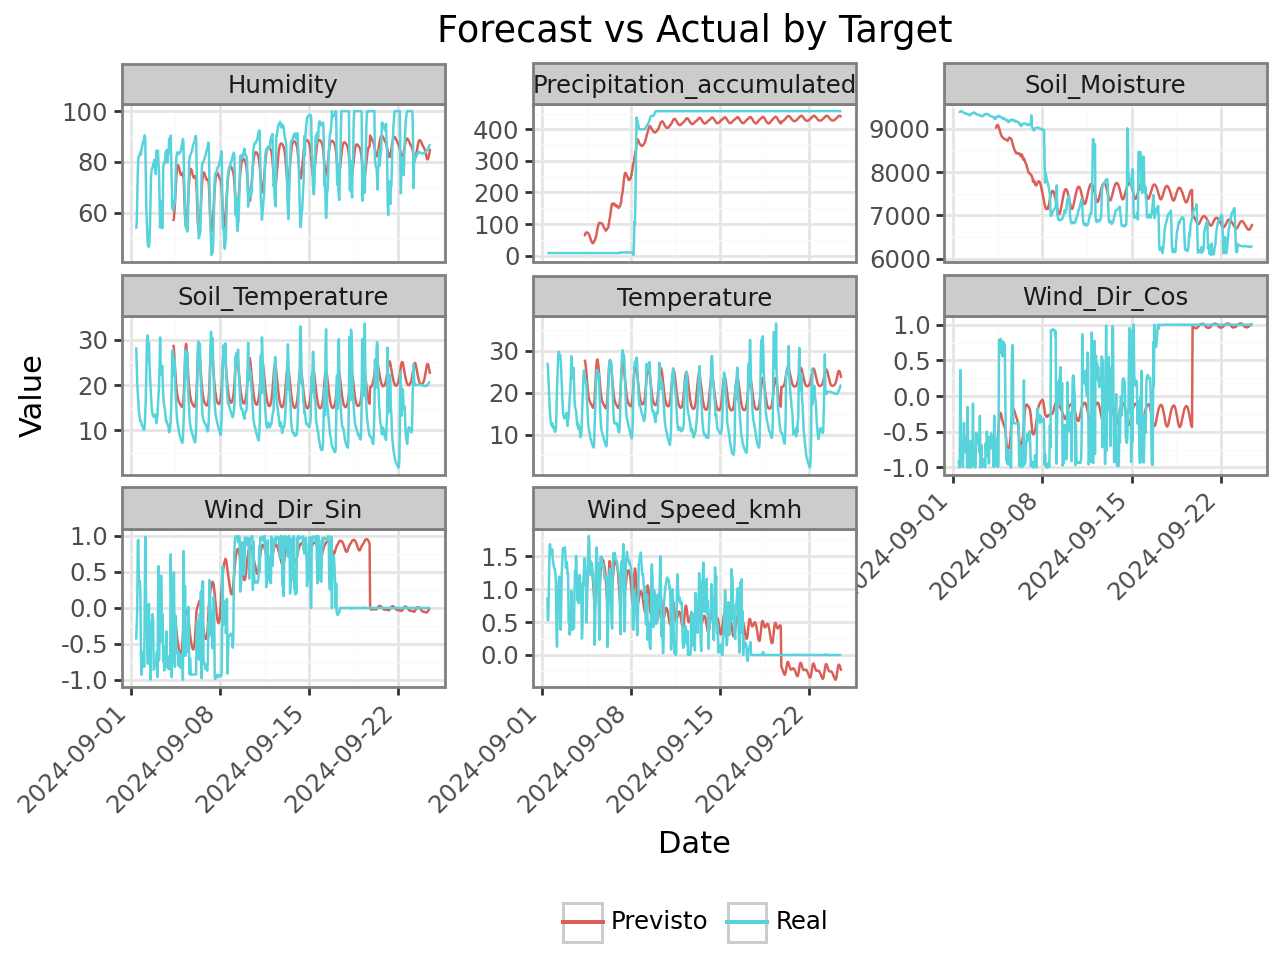

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    34.984702    5.914787    4.996719  0.230004   
Precipitation_accumulated    1054.178360   32.468113   29.269258 -1.864304   
Humidity                       91.882693    9.585546    7.837722  0.443362   
Wind_Speed_kmh                  0.138813    0.372576    0.331452  0.263500   
Soil_Moisture              479015.827433  692.109693  613.937742 -0.551227   
Soil_Temperature               36.295323    6.024560    5.186620  0.206410   
Wind_Dir_Sin                    0.401836    0.633905    0.510176 -1.023309   
Wind_Dir_Cos                    0.878948    0.937522    0.805860 -0.675987   

                                SMAPE  
Temperature                 33.491534  
Precipitation_accumulated    6.710303  
Humidity                     9.486972  
Wind_Speed_kmh             125.624998  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM//previsao_vs_real_168.png


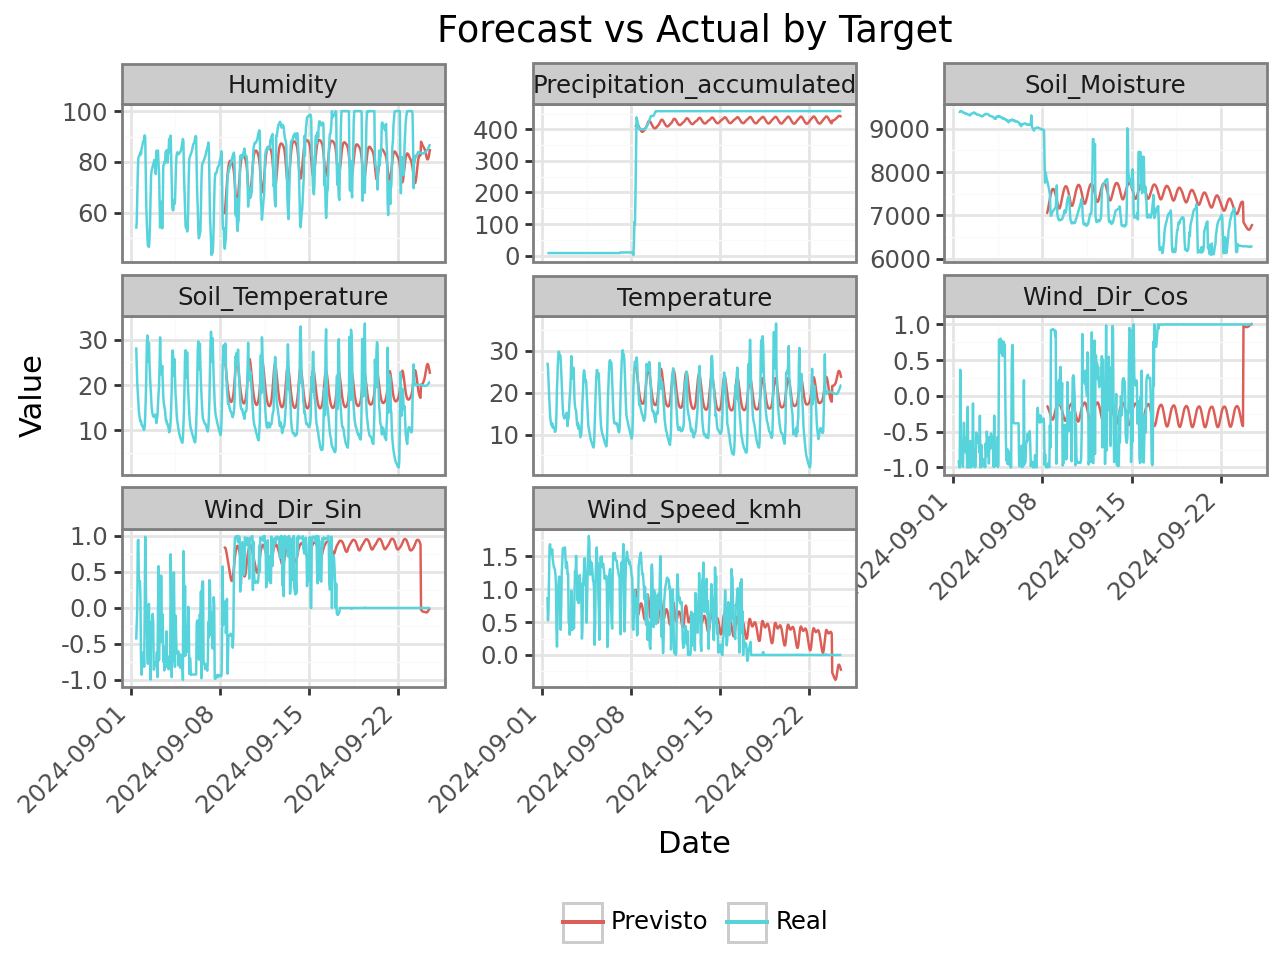

In [11]:
for forecast_horizon in [1,6,12,24,48,72,168]:
    forecasts = model.historical_forecasts(
        best_train_scaled,
        start=0.8,
        forecast_horizon=forecast_horizon,
        stride=1,
        retrain=False,
        last_points_only=True,
        predict_kwargs={"dataloader_kwargs":{"num_workers": 11}}
    )

    forecasts_t = best_scaler.inverse_transform(forecasts)
    s = best_scaler.inverse_transform(best_train_scaled).split_after(0.8)[1]
    metrics = {}
    print("Starting time series verification for consistency...")
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], forecasts_t[target]),
            'RMSE': rmse(s[target], forecasts_t[target]),
            'MAE': mae(s[target], forecasts_t[target]),
            'R2': r2_score(s[target], forecasts_t[target]),
            'SMAPE': smape(s[target], forecasts_t[target]),
        }
    metrics_df = pd.DataFrame(metrics).T
    print("\nPerformance metrics:")
    print(metrics_df)

    s_df = s.to_dataframe()
    s_df = s_df.reset_index()
    forecasts_t_df = forecasts_t.to_dataframe()
    forecasts_t_df = forecasts_t_df.reset_index()
    forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
    print(forecasts_t_df.columns)

    plot_columns = ['Timestamp'] + target_columns
    s_melted = s_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    s_melted['type'] = 'Real'

    forecasts_t_melted = forecasts_t_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    forecasts_t_melted['type'] = 'Previsto'

    # Concatena os DataFrames 'Real' e 'Previsto'
    df_combined = pd.concat([s_melted, forecasts_t_melted])

    # Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
    df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

    plot = (
            ggplot(df_combined, aes(x='Date', y='value', color='type'))
            + geom_line()
            + facet_wrap('~ target_column', scales='free_y') # Creates a subplot for each 'target_column'
            + labs(
        title='Forecast vs Actual by Target',
        x='Date',
        y='Value',
        color='Data Type' # Legend for color
    )
            + theme_bw()
            + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotates x-axis labels
        legend_position='bottom', # Places legend at the bottom
        legend_title=element_blank(), # Removes legend title
    )
    )

    plot.save(f'{result_path}/previsao_vs_real_{forecast_horizon}.png', width=12, height=10, dpi=300)
    plot.show()

    with open(f'{result_path}/metrics_{forecast_horizon}.json', 'w') as f:
        json.dump(metrics_df.to_dict(), f, indent=4)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

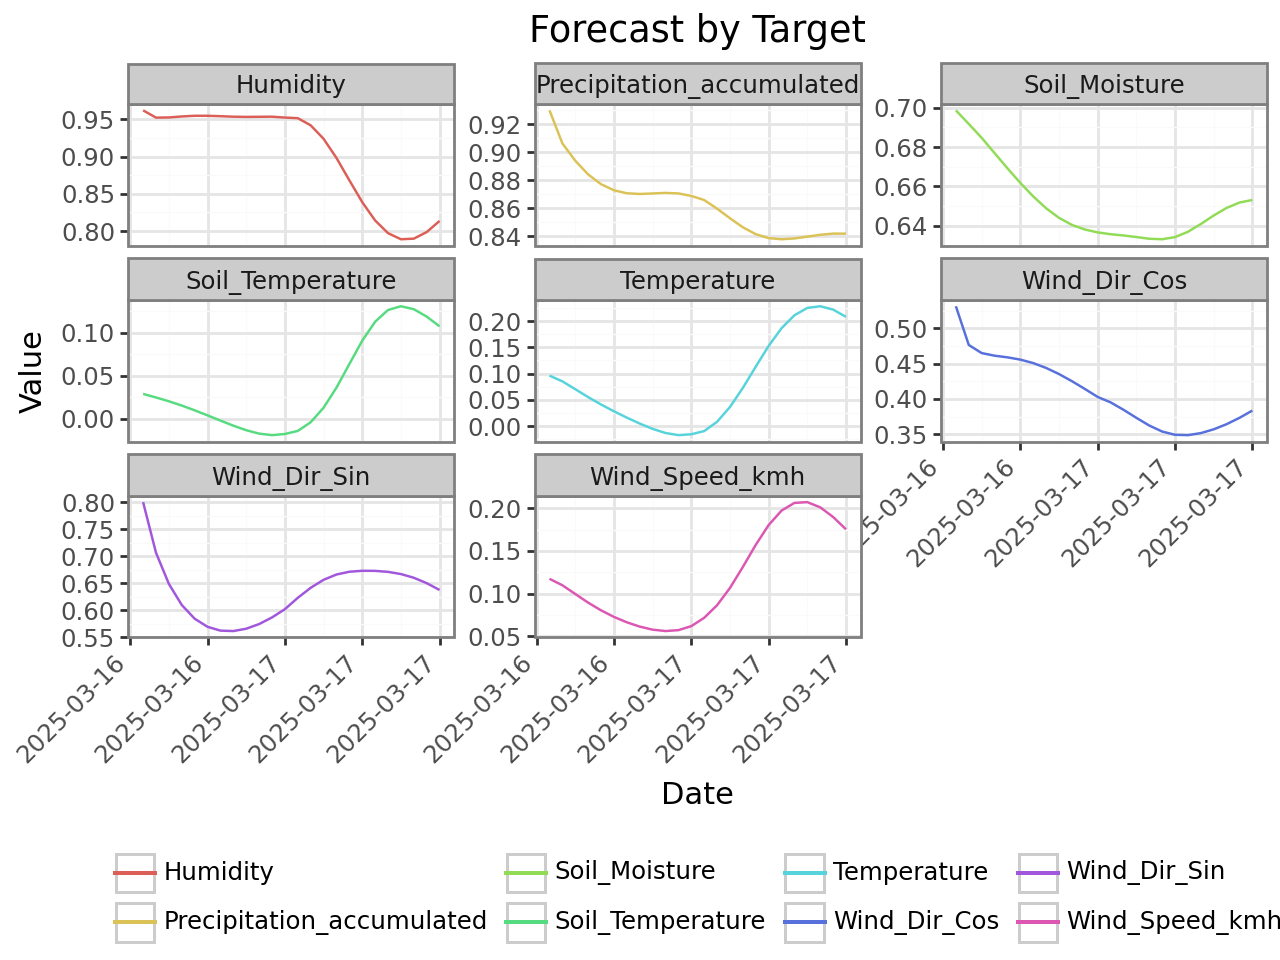

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/LSTM//pred_future_24.png


In [12]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
        ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y') # Creates a subplot for each 'target_column'
        + labs(
    title='Forecast by Target',
    x='Date',
    y='Value',
    color='Data Type' # Legend for color
)
        + theme_bw()
        + theme(
    axis_text_x=element_text(rotation=45, hjust=1), # Rotates x-axis labels
    legend_position='bottom', # Places legend at the bottom
    legend_title=element_blank(), # Removes legend title

)
)
plot.show()
plot.save(f'{result_path}/pred_future_24.png', width=12, height=10, dpi=300)
